# Preprocesamiento de los Datos

In [18]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Importamos los datos originales
X_train = pd.read_csv("../data/original/X_train.csv")
Y_train = pd.read_csv("../data/original/y_train.csv")

#### Fusionamos por ID los assets

In [5]:
df = X_train.merge(Y_train, on="id")

#### Inspección Inicial

In [12]:
print("Primeras filas del dataset combinado:")
display(df.head(3))

Primeras filas del dataset combinado:


,id,trq_measured,oat,mgt,pa,ias,np,ng,faulty,trq_margin
0,0,54.100,2.00000,544.5000,212.1408,74.56250,89.18000,99.6400,1,-13.717745
1,1,49.625,24.22231,578.4844,1625.6400,30.35596,99.55273,91.3866,0,1.791863
2,2,52.000,7.00000,566.1000,1912.9250,65.62500,100.14000,90.9600,1,-13.944871


In [13]:
print("Información general del dataset:")
df.info()
print("\nEstadísticas descriptivas:")
df.describe()

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742625 entries, 0 to 742624
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            742625 non-null  int64  
 1   trq_measured  742625 non-null  float64
 2   oat           742625 non-null  float64
 3   mgt           742625 non-null  float64
 4   pa            742625 non-null  float64
 5   ias           742625 non-null  float64
 6   np            742625 non-null  float64
 7   ng            742625 non-null  float64
 8   faulty        742625 non-null  int64  
 9   trq_margin    742625 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 56.7 MB

Estadísticas descriptivas:


,id,trq_measured,oat,mgt,pa,ias,np,ng,faulty,trq_margin
count,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000,742625.000000
mean,371312.000000,65.097549,12.675167,592.246116,511.776065,79.324591,97.377919,95.517281,0.403189,-1.157346
std,214377.516166,13.253672,8.066084,39.654582,563.190555,35.395075,3.996721,3.635084,0.490538,14.068843
min,0.000000,14.673340,-19.250000,467.300000,-208.389200,0.000000,85.010000,90.001830,0.000000,-74.747111
25%,185656.000000,56.100000,7.500000,562.400000,135.331200,51.125000,95.330000,92.226440,0.000000,-6.604321
50%,371312.000000,65.700000,13.703440,589.400000,340.461600,88.375000,99.759770,94.810000,0.000000,1.693847
75%,556968.000000,75.500000,18.500000,622.300000,588.264000,110.562500,100.020000,99.900000,1.000000,7.785348
max,742624.000000,104.730500,36.799130,723.400000,3097.510000,137.562500,101.560000,101.220000,1.000000,34.148857


#### Revisamos nulos y outliers

In [8]:
df.isna().sum()

id              0
trq_measured    0
oat             0
mgt             0
pa              0
ias             0
np              0
ng              0
faulty          0
trq_margin      0
dtype: int64

####  Distribución de la variable  faulty

In [30]:
print("Distribución de clases en 'faulty':")
print(df['faulty'].value_counts(normalize=True))

Distribución de clases en 'faulty':
faulty
0    0.596811
1    0.403189
Name: proportion, dtype: float64


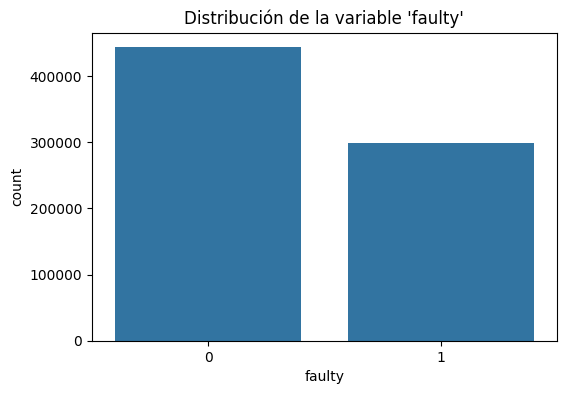

In [19]:
plt.figure(figsize=(6,4))
sns.countplot(x='faulty', data=df)
plt.title("Distribución de la variable 'faulty'")
plt.show()

#### Estadísticas y distribución de trq_margin

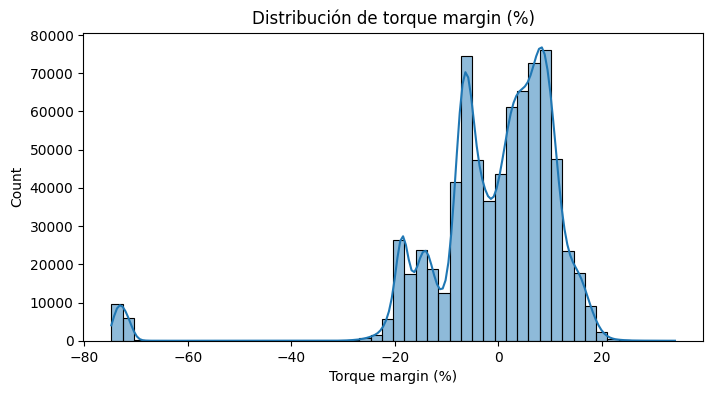

In [20]:
plt.figure(figsize=(8,4))
sns.histplot(df['trq_margin'], bins=50, kde=True)
plt.title("Distribución de torque margin (%)")
plt.xlabel("Torque margin (%)")
plt.show()

In [21]:
print("Descripción de torque margin:")
display(df['trq_margin'].describe())

Descripción de torque margin:


count    742625.000000
mean         -1.157346
std          14.068843
min         -74.747111
25%          -6.604321
50%           1.693847
75%           7.785348
max          34.148857
Name: trq_margin, dtype: float64

#### Boxplot para ver outliers en torque margin

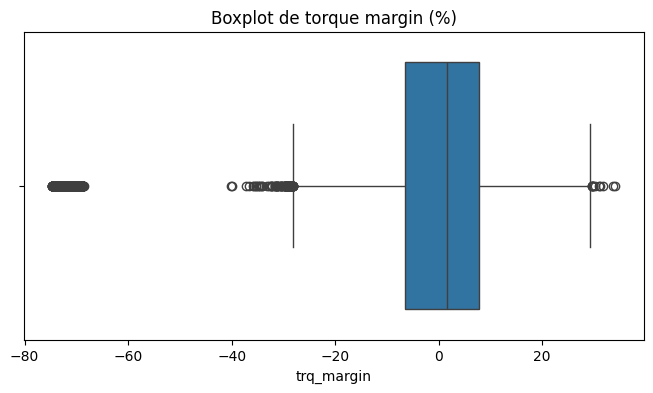

In [22]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df['trq_margin'])
plt.title("Boxplot de torque margin (%)")
plt.show()

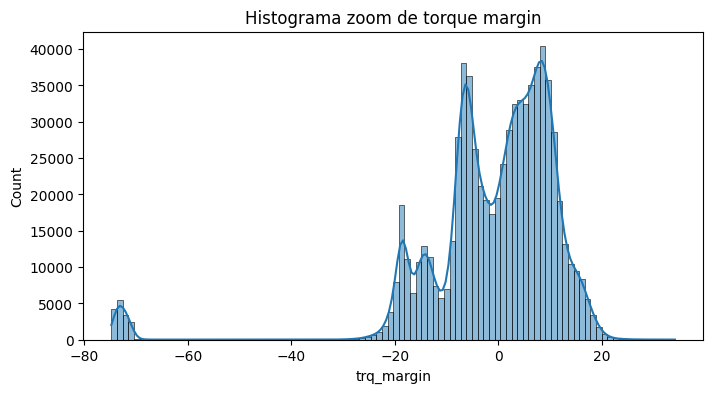

In [32]:
plt.figure(figsize=(8,4))
sns.histplot(df['trq_margin'], bins=100, kde=True)
plt.title("Histograma zoom de torque margin")
plt.show()

#### Zoom al histograma en rango -20 a 20 para ver distribución central mejor

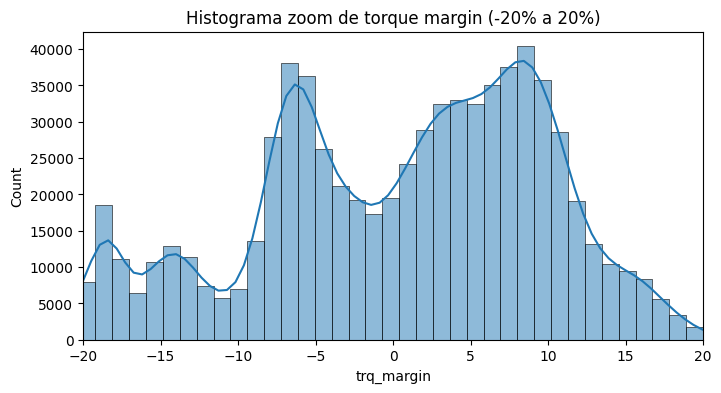

In [23]:
plt.figure(figsize=(8,4))
sns.histplot(df['trq_margin'], bins=100, kde=True)
plt.xlim(-20, 20)
plt.title("Histograma zoom de torque margin (-20% a 20%)")
plt.show()

####  Estadísticas para decidir tratamiento

In [24]:
q_low = df['trq_margin'].quantile(0.01)
q_high = df['trq_margin'].quantile(0.99)
print(f"Percentil 1%: {q_low:.2f}, Percentil 99%: {q_high:.2f}")

Percentil 1%: -72.93, Percentil 99%: 17.61


##### Winsorizing: limitar valores extremos a percentiles 1 y 99
El Winsorizing evita que valores extremos exagerados afecten la regresión.

In [25]:
df['trq_margin_wins'] = df['trq_margin'].clip(lower=q_low, upper=q_high)

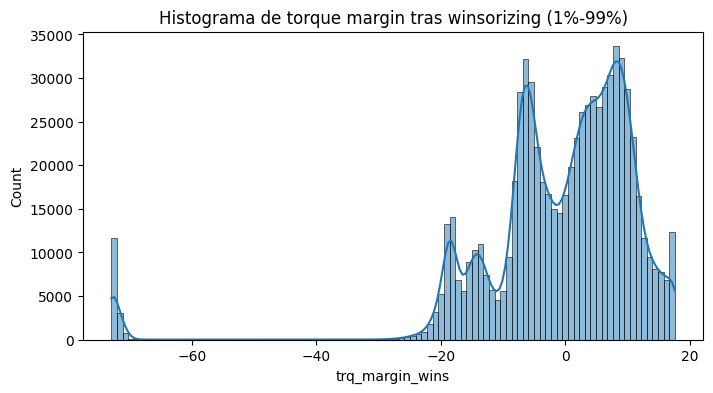

In [26]:
plt.figure(figsize=(8,4))
sns.histplot(df['trq_margin_wins'], bins=100, kde=True)
plt.title("Histograma de torque margin tras winsorizing (1%-99%)")
plt.show()

####  Agregar columna winsorizada al DataFrame limpio 

In [34]:
df_clean = df.copy()
df_clean['trq_margin_wins'] = df['trq_margin_wins']

#### Separar features para clasificación y regresión

In [ ]:
X_cls = df_clean.drop(columns=['faulty', 'trq_margin_wins'])
Y_cls = df_clean['faulty']

X_reg = df_clean.drop(columns=['faulty'])
Y_reg = df_clean['trq_margin_wins']